In [249]:
import pandas as pd

In [250]:
result = pd.read_csv('./total_padded_encoded_df.csv')
data = pd.DataFrame(result)
data.head()

,Unnamed: 0,genre,1,2,3,4,5,6,7,8,...,843,844,845,846,847,848,849,850,851,852
0,0,1,0,2,3,0,0,4,0,5,...,1,1,1,1,1,1,1,1,1,1
1,1,1,31,41,42,43,44,45,0,46,...,1,1,1,1,1,1,1,1,1,1
2,2,1,138,139,140,0,0,0,141,0,...,1,1,1,1,1,1,1,1,1,1
3,3,1,117,0,203,0,204,205,206,0,...,1,1,1,1,1,1,1,1,1,1
4,4,1,284,0,285,286,287,0,288,288,...,1,1,1,1,1,1,1,1,1,1


In [251]:
data['genre'] = data['genre'].replace({1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7})

# feature, label 분리

In [252]:
feature_df = data.iloc[:, 2:]
label_df = data[['genre']]
print(feature_df.shape, label_df.shape)

(772, 852) (772, 1)


In [253]:
feature_df.head()

,1,2,3,4,5,6,7,8,9,10,...,843,844,845,846,847,848,849,850,851,852
0,0,2,3,0,0,4,0,5,6,7,...,1,1,1,1,1,1,1,1,1,1
1,31,41,42,43,44,45,0,46,0,47,...,1,1,1,1,1,1,1,1,1,1
2,138,139,140,0,0,0,141,0,143,0,...,1,1,1,1,1,1,1,1,1,1
3,117,0,203,0,204,205,206,0,118,207,...,1,1,1,1,1,1,1,1,1,1
4,284,0,285,286,287,0,288,288,289,290,...,1,1,1,1,1,1,1,1,1,1


In [254]:
label_df.head()

,genre
0,0
1,0
2,0
3,0
4,0


In [255]:
# label_df = label_df.replace({1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7})

In [256]:
label_df['genre'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [257]:
label_df.head()

,genre
0,0
1,0
2,0
3,0
4,0


# DataSet 생성, Tensor 변환, DataLoader 생성

In [258]:
from torch.utils.data import Dataset, DataLoader, random_split

import torch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.x_data = data.iloc[:, 2:].values
        self.y_data = data[['genre']].values
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,idx):
        x = torch.LongTensor(self.x_data[idx])
        y = torch.LongTensor(self.y_data[idx])
        return x, y

In [259]:
DS = CustomDataset()

num = int(len(DS) * 0.9)
print(num)
# print(DS[0])

694


In [260]:
# 학습용과 테스트용으로 분리
train_ds, test_ds = random_split(DS, [num, len(DS) - num])

In [261]:
# 데이터 로더 생성
BATCH = 20
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle = True)
test_loader = DataLoader(test_ds, batch_size = BATCH, shuffle = True)

In [262]:
for x, y in train_loader:
    # print(f'y : {y}\nx : {x}')
    break

# 모델 설계

In [263]:
import torch.nn as nn
class music_rnn(nn.Module):
    def __init__(self, VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASS):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE+2, embedding_dim=EMBED_DIM)
        self.rnn = nn.RNN(input_size=EMBED_DIM, hidden_size=HIDDEN_SIZE, batch_first = True)
        # 학습 모델을 RNN 대신에 LSTM을 사용해볼수도 있겠다
        # RNN에서 양방향 학습 파라미터를 설정해볼 수 도 있겠다.
        
        # 활성화함수 => 다중 분류니까
        # self.fc = nn.Softmax(HIDDEN_SIZE, NUM_CLASS) # 이렇게 쓰는게 아닌가?
        self.fc = nn.Linear(HIDDEN_SIZE, NUM_CLASS) # 다중 분류인데 이게 되나?
        
        self.init_weights() # 이건 왜 쓴거지?
        self.dropout = nn.Dropout()  # 혹시 모를 과대적합을 위해서
        
    # 가중치 초기화
    def init_weights(self):
        range = 0.5
        self.embedding.weight.data.uniform_(-range, range)
        # self.fc.weight.data.uniform_(-range, range)
        # self.fc.bias.data.zero_()
        
    # 순방향 학습 진행
    def forward(self, text):
        embed = self.embedding(text)
        output, hidden = self.rnn(embed)
        output=output[:,-1,:]     ## 수정
        result = self.fc(output)
        # result = F.softmax(self.fc(output), dim=1)
        return result

In [264]:
# 학습용 변수들 지정
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
VOCAB_SIZE = 13714
EMBED_DIM = 50
HIDDEN_SIZE = 10
NUM_CLASS = 8
model = music_rnn(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASS)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params = model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [265]:
model

music_rnn(
  (embedding): Embedding(13716, 50)
  (rnn): RNN(50, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# 함수 지정 (train, test)

In [266]:
import torchmetrics.functional.classification as metrics
import numpy as np

In [267]:
def training(DATALOADER):
    model.train()
    output_list = [[], [], [], [], []]
    # loss, acc, precision, recall, f1_score
    for (feature, label) in DATALOADER:
        feature = feature.to(device)
        label = label.to(device)
        ### 수정 된 부분
        label_oh=F.one_hot(label, num_classes=8)
        label_oh.squeeze_(dim=1)
        pred = model(feature)
        
        # 손실 검정
        loss = loss_fn(pred, label_oh.float())
        output_list[0].append(loss.item())
        output_list[1].append(metrics.accuracy(pred, label_oh, task = 'binary').item())
        output_list[2].append(metrics.precision(pred, label_oh, task = 'binary').item())
        output_list[3].append(metrics.recall(pred, label_oh, task = 'binary').item())
        output_list[4].append(metrics.f1_score(pred, label_oh, task = 'binary').item())

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss = round(sum(output_list[0]) / len(output_list[0]), 4)
    total_acc = round(sum(output_list[1])/len(output_list[1]), 4)
    total_prec = round(sum(output_list[2])/len(output_list[2]), 4)
    total_recall = round(sum(output_list[3])/len(output_list[3]), 4)
    total_f1 = round(sum(output_list[4])/len(output_list[4]), 4)
    
    print(f"< 1개의 에포크 train 후 result >")
    print(f"loss {total_loss}   acc {total_acc}   precision {total_prec}   recall {total_recall}   f1_score {total_f1}")
    return total_loss, total_acc, total_prec, total_recall, total_f1
# training(train_loader)

In [268]:
def testing(DATALOADER):
    model.eval()
    output_list = [[], [], [], [], []]
    # loss, acc, precision, recall, f1_score
    for (feature, label) in DATALOADER:
        feature = feature.to(device)
        label = label.to(device)
        ### 수정 된 부분
        label_oh=F.one_hot(label, num_classes=8)
        label_oh.squeeze_(dim=1)
        pred = model(feature)
        
        # 손실 검정
        loss = loss_fn(pred, label_oh.float())
        output_list[0].append(loss.item())
        output_list[1].append(metrics.accuracy(pred, label_oh, task = 'binary').item())
        output_list[2].append(metrics.precision(pred, label_oh, task = 'binary').item())
        output_list[3].append(metrics.recall(pred, label_oh, task = 'binary').item())
        output_list[4].append(metrics.f1_score(pred, label_oh, task = 'binary').item())

    total_loss = round(sum(output_list[0]) / len(output_list[0]), 4)
    total_acc = round(sum(output_list[1])/len(output_list[1]), 4)
    total_prec = round(sum(output_list[2])/len(output_list[2]), 4)
    total_recall = round(sum(output_list[3])/len(output_list[3]), 4)
    total_f1 = round(sum(output_list[4])/len(output_list[4]), 4)
    
    print(f"< 1개의 에포크 test 후 result >")
    print(f"loss {total_loss}   acc {total_acc}   precision {total_prec}   recall {total_recall}   f1_score {total_f1}")
    return total_loss, total_acc, total_prec, total_recall, total_f1

# testing(test_loader)

# 학습 진행

In [269]:
EPOCH = 10
ep_train_result = [[], [], [], [], []]
ep_test_result = [[], [], [], [], []]
for epoch in range(EPOCH):
    # 학습
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1 = training(train_loader)
    ep_train_result[0].append(tr_loss)
    ep_train_result[1].append(tr_acc)
    ep_train_result[2].append(tr_prec)
    ep_train_result[3].append(tr_rec)
    ep_train_result[4].append(tr_f1)
    print(f"{epoch + 1}번쨰 학습 완료")
    # 검증
    ts_loss, ts_acc, ts_prec, ts_rec, ts_f1 = testing(test_loader)
    ep_test_result[0].append(ts_loss)
    ep_test_result[1].append(ts_acc)
    ep_test_result[2].append(ts_prec)
    ep_test_result[3].append(ts_rec)
    ep_test_result[4].append(ts_f1)
    print(f"{epoch + 1}번쨰 검증 완료")

< 1개의 에포크 train 후 result >
loss 2.0994   acc 0.5839   precision 0.1234   recall 0.379   f1_score 0.1832
1번쨰 학습 완료
< 1개의 에포크 test 후 result >
loss 2.0792   acc 0.6927   precision 0.1354   recall 0.2708   f1_score 0.1806
1번쨰 검증 완료
< 1개의 에포크 train 후 result >
loss 2.0854   acc 0.671   precision 0.135   recall 0.3004   f1_score 0.1851
2번쨰 학습 완료
< 1개의 에포크 test 후 result >
loss 2.0905   acc 0.6795   precision 0.109   recall 0.2181   f1_score 0.1454
2번쨰 검증 완료
< 1개의 에포크 train 후 result >
loss 2.079   acc 0.7417   precision 0.1453   recall 0.2127   f1_score 0.1678
3번쨰 학습 완료
< 1개의 에포크 test 후 result >
loss 2.0889   acc 0.7788   precision 0.1153   recall 0.1153   f1_score 0.1153
3번쨰 검증 완료
< 1개의 에포크 train 후 result >
loss 2.0787   acc 0.8026   precision 0.1268   recall 0.1276   f1_score 0.1272
4번쨰 학습 완료
< 1개의 에포크 test 후 result >
loss 2.0961   acc 0.7788   precision 0.1153   recall 0.1153   f1_score 0.1153
4번쨰 검증 완료
< 1개의 에포크 train 후 result >
loss 2.076   acc 0.7883   precision 0.1407   recall 0.1427   f

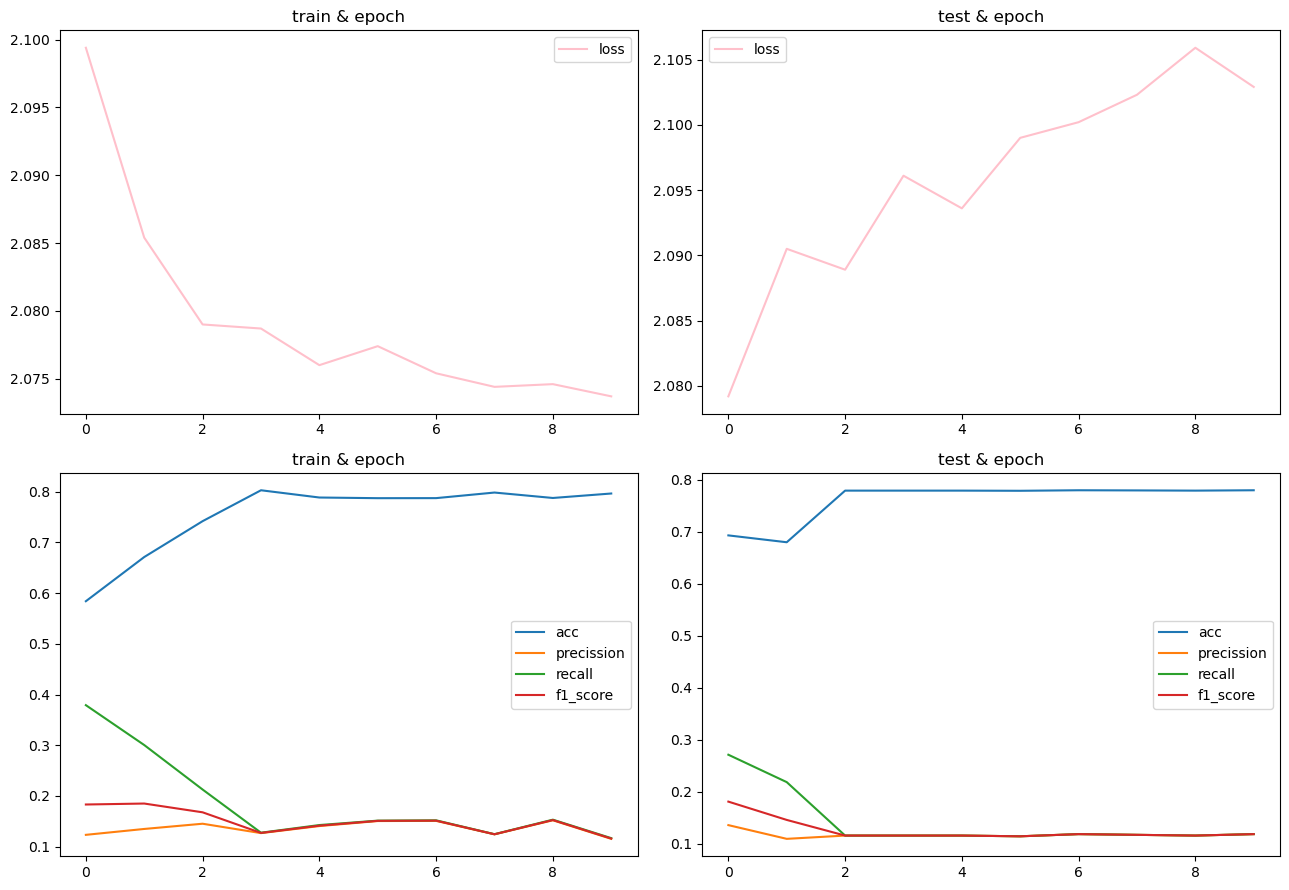

In [279]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,9))

plt.subplot(2,2,1)
plt.plot(ep_train_result[0], label = 'loss', color = 'pink')
plt.legend()
plt.title('train & epoch')

plt.subplot(2,2,2)
plt.plot(ep_test_result[0], label = 'loss', color = 'pink')
plt.legend()
plt.title('test & epoch')

plt.subplot(2,2,3)
# plt.plot(ep_train_result[0], label = 'loss')
plt.plot(ep_train_result[1], label = 'acc')
plt.plot(ep_train_result[2], label = 'precission')
plt.plot(ep_train_result[3], label = 'recall')
plt.plot(ep_train_result[4], label = 'f1_score')
plt.legend()
plt.title('train & epoch')

plt.subplot(2,2,4)
# plt.plot(ep_test_result[0], label = 'loss')
plt.plot(ep_test_result[1], label = 'acc')
plt.plot(ep_test_result[2], label = 'precission')
plt.plot(ep_test_result[3], label = 'recall')
plt.plot(ep_test_result[4], label = 'f1_score')
plt.legend()
plt.title('test & epoch')

plt.tight_layout()
plt.show()

In [271]:
print(f"{EPOCH}번 학습을 돌렸을 떄 최종 결과는 다음과 같다.")
LOSS = round(sum(ep_test_result[0])/len(ep_test_result[0]),3)
ACC = round(sum(ep_test_result[1])/len(ep_test_result[1]),3)
PREC = round(sum(ep_test_result[2])/len(ep_test_result[2]),3)
RECALL = round(sum(ep_test_result[3])/len(ep_test_result[3]),3)
F1_SCORE = round(sum(ep_test_result[4])/len(ep_test_result[4]),3)

print(f"[Loss] {LOSS} [Accuracy] {ACC} [Precision] {PREC} [RECALL] {RECALL} [f1_score] {F1_SCORE}")

10번 학습을 돌렸을 떄 최종 결과는 다음과 같다.
[Loss] 2.096 [Accuracy] 0.76 [Precision] 0.117 [RECALL] 0.142 [f1_score] 0.125


# 예측

In [280]:
sample_text = """
Baby\nI’m just trying to play it cool\nBut I just can’t hide that\nI want you\n\nWait a minute 이게 뭐지?\n내 심장이 lub-dub\n자꾸만 뛰어\n\n저 멀리서도 oh my gosh!\n끌어당겨 you’re my crush!\n초능력처럼\n\n거대한 자석이 된 것만 같아 my heart\n네 모든 게 내 맘에 달라붙어버려 boy\n\nWe’re magnetized 인정할게\nThis time I want\n\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\n\nBAE BAE BAE BAE BAE BAE BAE BAE BAE\nDash-da-da Dash-da-da Dash-da\nLike it’s magnetic\nBAE BAE BAE BAE BAE BAE BAE BAE BAE\nDash-da-da Dash-da-da\nBaby don’t say no\n\n정반대 같아 our type\n넌 J 난 완전 P\nS와 N 극이지만\n그래서 끌리지\n\n내가 만들래 green light\n여잔 배짱이지\nSo let’s go let’s go\nLet’s go let’s go\n\n숨기고 싶지 않아 자석 같은 my heart\n내 맘의 끌림대로 너를 향해 갈게 boy\n\nWe’re magnetized 인정할게\nThis time I want\n\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\n\nNo push and pull\n전속력으로 너에게 갈게\n(In a rush in a rush)\nOur chemistry\n난 과몰입해 지금 순간에\n(Baby you’re my crush you’re my crush)\n\nNo push and pull\n네게 집중 후회는 안 할래\n(Gonna dash gonna dash)\nNever holding back\n직진해 yeah\nThis time I want\n\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\nYou You You You like it’s magnetic\nU U U U U U U U super 이끌림\n\nBAE BAE BAE BAE BAE BAE BAE BAE BAE\nDash-da-da Dash-da-da Dash-da\nLike it’s magnetic\nBAE BAE BAE BAE BAE BAE BAE BAE BAE\nDash-da-da Dash-da-da\nBaby don’t say no
"""

# 아일릿 - 마그네틱